In [1]:
import numpy as np
import matplotlib.pyplot as plt
from trotter import *

# Clock Hamiltonian

\begin{equation}
H=J\sum_i \sum_{m=1}^{n-1} \alpha_m \sigma_i^m \sigma_{i+1}^{-m}+g\sum_i \sum_{m=1}^{n-1} \beta_m \tau_i^m
\end{equation}

In [2]:
dim = 3 # order of the clock (n) 
g = -0.2; J = float("{0:.5f}".format(-1-g)); theta = np.pi/3; phi = 0;
alpha = np.array([np.exp(1j*theta),np.exp(-1j*theta)])
beta = np.array([np.exp(1j*phi),np.exp(1j*phi)])

chi = 10; delta = 0.01; N = 500

#### Construct operators

In [3]:
sigma = np.diag(np.exp(1j*2*np.pi*np.arange(dim)/dim))
tau = np.roll(np.eye(dim), -1, axis = -1)
interactions = list(zip(J*alpha, [sigma**m for m in range(1,dim)], [sigma**(dim-m) for m in range(1,dim)]))
transv_field = list(zip(g*beta, [tau**m for m in range(1,dim)]))
U=ST_step(delta, interactions, transv_field)

#### Initialization with random state

In [54]:
GA0 = np.random.rand(dim,chi,chi)
LA0 = np.random.rand(chi)
GB0 = np.random.rand(dim,chi,chi)
LB0 = np.random.rand(chi)

#### iTEBD

In [56]:
res={}
res_names = ["Energy", "SigmaA", "SigmaB"]

GA = GA0; LA = LA0; GB = GB0; LB = LB0
discarded_weights = []
for step in range(N):
    GA, LA, GB, dw, norm_sq = iTEDB(dim, chi, GA, LA, GB, LB, U)
    E_sim =-np.log(norm_sq)/delta/2
    discarded_weights.append(dw)
    GB, LB, GA, dw, norm_sq = iTEDB(dim, chi, GB, LB, GA, LA, U)
    E_sim =-np.log(norm_sq)/delta/2
    discarded_weights.append(dw)
res["Energy"] = E_sim
res["SigmaA"] = np.einsum('sab,tab,st,b,a->', GA, np.conj(GA), sigma, LA**2, LB**2)
res["SigmaB"] = np.einsum('sab,tab,st,b,a->', GB, np.conj(GB), sigma, LB**2, LA**2)
#res["SigmaAdagSigmaB"] = np.einsum('sab,tac,st,b,c,vbd,wcd,vw,a,d->',
#                                   GA, np.conj(GA), sigma**2, LA, LA, GB, np.conj(GB), sigma, LB**2, LB**2)

for key in res_names: print(key, res[key])
print(np.exp(1j*theta))
print("Discarder weights", discarded_weights[-10:])
print("Entanglement spectrum", LB**2)

Energy -0.9540523283159128
SigmaA (0.002106057508052831+0.000620591534160369j)
SigmaB (0.0013787301648877973+0.0021790014315824j)
(0.5000000000000001+0.8660254037844386j)
Discarder weights [2.5578785504938368e-05, 2.5652207317813146e-05, 2.5711023633503407e-05, 2.5784364928780068e-05, 2.5843549794738243e-05, 2.5916815490194277e-05, 2.597636321475859e-05, 2.6049558175828367e-05, 2.6109463114646672e-05, 2.6182592153803667e-05]
Entanglement spectrum [7.28641367e-01 1.36134701e-01 1.33994304e-01 5.88745928e-04
 2.17939471e-04 2.17230951e-04 1.01950640e-04 1.00357331e-04
 3.35546876e-06 4.85701633e-08]


#### Save to file

In [6]:
# File_code = '{}J_{}g_{}theta_{}phi_{}Chi_{}delta_{}N'.format(J, g, theta, phi, chi, delta,N)
# !mkdir -p {'clock3/data_'+File_code}

# Outfile1 = './clock3/data_{}/Results.dat'.format(File_code)
# Outfile2 = './clock3/data_{}/EntanglementSpectrum.dat'.format(File_code)
# Outfile3 = './clock3/data_{}/DiscardedWeights.dat'.format(File_code)

# with open(Outfile1, 'w') as f1:
#     print('# ', File_code, file=f1)
#     print('# ', *res_names, file=f1)
#     print(*[res[key] for key in res_names], file=f1)
# np.savetxt(Outfile2, LB**2, header=File_code)
# np.savetxt(Outfile3, discarded_weights, header=File_code)

# Analysis of the 3-state clock model

\begin{equation}
H=J\sum_i (e^{i\theta}\sigma_i \sigma_{i+1}^\dagger + h.c.)+g\sum_i (e^{i\varphi} \tau_i+h.c.)
\end{equation}

In [5]:
import glob
import re

#### Read data files

In [58]:
datalist=[]
for name in glob.glob('clock3/data_*J_*g_*theta_*phi_*Chi_*delta_*N'):
    ES = np.loadtxt('{}/EntanglementSpectrum.dat'.format(name))
    EE = -np.sum(ES*np.log(ES))
    res = np.genfromtxt('{}/Results.dat'.format(name), dtype=(np.float64, np.complex128, np.complex128))
    m = re.match('clock3/data_(.*)J_(.*)g_(.*)theta_(.*)phi_(.*)Chi_(.*)delta_(.*)N', name)
    datalist.append(np.array([(*m.groups(), *res.item(), EE)],\
             dtype=[\
                    ('J', np.float64), ('g', np.float64), ('theta', np.float64),\
                    ('phi', np.float64), ('chi', np.int32), ('delta', np.float64), ('N', np.int32),\
                    ('Energy', np.float64), ('SigmaA', np.complex128), ('SigmaB', np.complex128),\
                    ('EE', np.float64)]))
datalist = sorted(datalist, key= lambda x: (x['phi'], x['J'], x['theta']))
data = np.array(datalist)
data = np.reshape(data, (3,11,11))

#### Plot

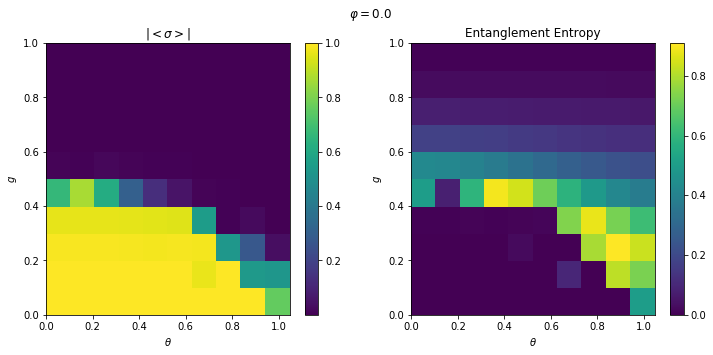

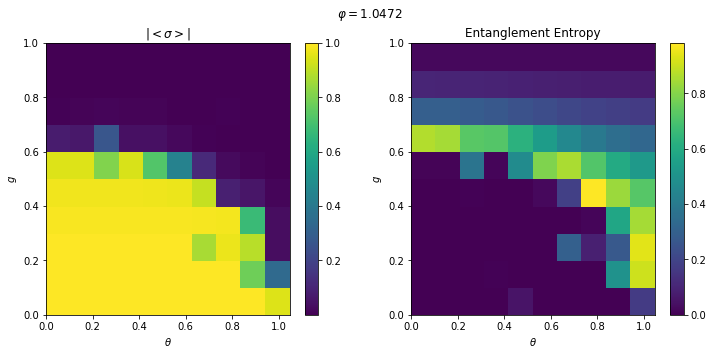

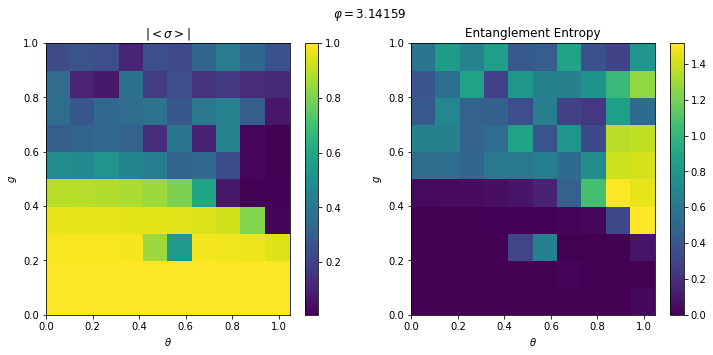

In [59]:
for dataset in data:
    fig, axes = plt.subplots(1,2, figsize=(12,5))

    c1 = axes[0].pcolor(dataset['theta'], -dataset['g'], np.abs(dataset['SigmaA']))
    c2 = axes[1].pcolor(dataset['theta'], -dataset['g'], np.abs(dataset['EE']))
    axes[0].set_title(r'$|<\sigma>|$')
    axes[1].set_title('Entanglement Entropy')
    for ax in axes:
        ax.set_xlabel(r'$\theta$')
        ax.set_ylabel(r'$g$')
    fig.colorbar(c1, ax=axes[0])
    fig.colorbar(c2, ax=axes[1])
    plt.suptitle(r'$\varphi={}$'.format(dataset['phi'][0,0]))
    plt.show()

Results obtained with $\chi = 10$, $\delta = 0.01$, $N = 500$

### Results in literature
![](plotz3.png)
*Phase diagram of the 
$\mathbb{Z}_3$ parafermionic chain with chiral interactions*
Ye Zhuang, Hitesh J. Changlani, Norm M. Tubman, and Taylor L. Hughes
Phys. Rev. B 92, 035154

# Read new files

In [9]:
def Observable(operator, LB, GA, LA):
    return np.einsum('sab,tab,st,b,a->', GA, np.conj(GA), operator, LA**2, LB**2)

def Correlator(op1, op2, GA, GB, LA, LB, r, chi):
    G, Gn, L, Ln = GA, GB, LA, LB
    r = int(r)
    OR = np.einsum('a,st,sba,tca->bc', L**2, op2, G, np.conj(G))
    L, Ln, G, Gn = Ln, L, Gn, G
    for _ in range(r-1):
        OR = np.einsum('bc,sdb,sec,b,c->de',OR,G,np.conj(G),L,L)
        L, Ln, G, Gn = Ln, L, Gn, G
    return np.einsum('d,sdb,tdc,b,c,bc,st->', Ln**2, G, np.conj(G), L, L, OR, op1)

def String_correlator(op1, op2, opstr, GA, GB, LA, LB, r, chi):
    G, Gn, L, Ln = GA, GB, LA, LB
    r = int(r)
    ORight = np.einsum('a,st,sba,tca->bc', L**2, op2, G, np.conj(G))
    L, Ln, G, Gn = Ln, L, Gn, G
    for _ in range(r-1):
        ORight = np.einsum('bc,sdb,tec,b,c,st->de',OR,G,np.conj(G),L,L,opstr)
        L, Ln, G, Gn = Ln, L, Gn, G
    return np.einsum('d,sdb,tdc,b,c,bc,st->', Ln**2, G, np.conj(G), L, L, ORight, op1)

In [63]:
data = []
folders=['phi0','phipi3', 'phitheta']
#folders=['phipi3_largerchi']
for folder in folders:
    datalist=[]
    for name in glob.glob('{}/data_*J_*g_*theta_*phi_*Chi_*delta_*N'.format(folder)):
        m = re.match('{}/data_(.*)J_(.*)g_(.*)theta_(.*)phi_(.*)Chi_(.*)delta_(.*)N'.format(folder), name)
        chi = int(m.groups()[4])
        Energy = np.loadtxt('{}/Energy.dat'.format(name))
        GA = np.loadtxt('{}/GammaA.dat'.format(name)).reshape(3,chi,chi)
        GB = np.loadtxt('{}/GammaB.dat'.format(name)).reshape(3,chi,chi)
        LA = np.loadtxt('{}/LambdaA.dat'.format(name))
        LB = np.loadtxt('{}/LambdaB.dat'.format(name))
        DW = np.loadtxt('{}/DiscardedWeights.dat'.format(name))
        ES = LB**2
        EE = -np.sum(ES*np.log(ES))
        SigmaA=Observable(sigma,LB,GA,LA)
        NNCorr=Correlator(sigma, sigma**2, GA, GB, LA, LB, 1, chi)

        datalist.append(np.array([(*m.groups(), Energy, GA, GB, LA, LB, EE, SigmaA, NNCorr, DW[-1])],\
                 dtype=[\
                        ('J', np.float64), ('g', np.float64), ('theta', np.float64),\
                        ('phi', np.float64), ('chi', np.int32), ('delta', np.float64), ('N', np.int32),\
                        ('Energy', np.float64), ('GammaA', np.complex128, (3,chi,chi)),\
                        ('GammaB', np.complex128, (3,chi,chi)),\
                        ('LambdaA', np.complex128, (chi)), ('LambdaB', np.complex128, (chi)),
                        ('EE', np.float64), ('SigmaA', np.complex128), ('NNCorr', np.complex128),
                        ('DW', np.float64)]))
    datalist = sorted(datalist, key= lambda x: (x['J'], x['theta']))
    data.append(np.array(datalist).reshape(21,21))

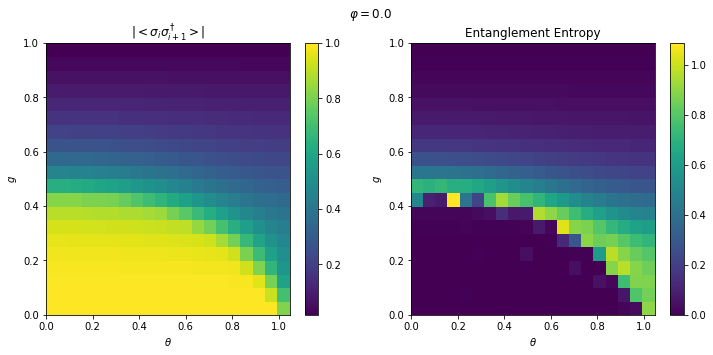

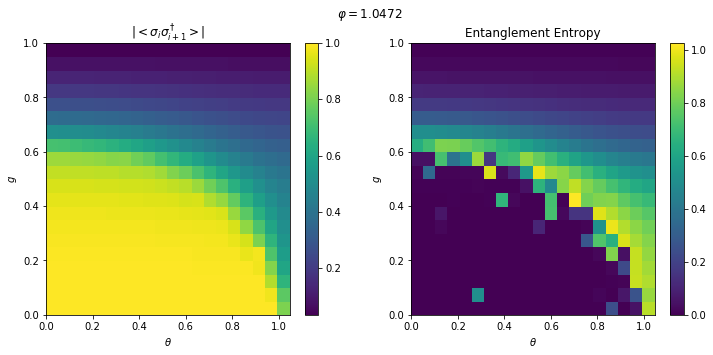

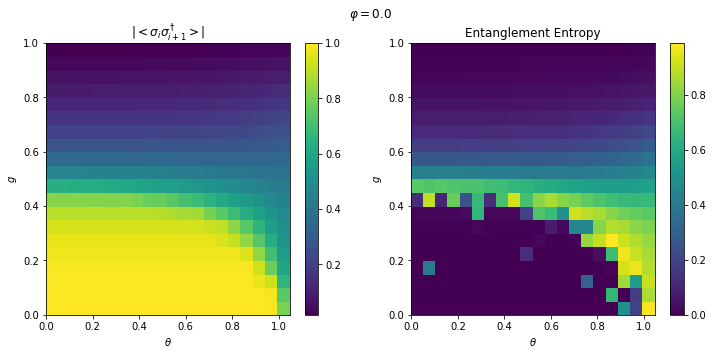

In [67]:
for dataset in data:
    fig, axes = plt.subplots(1,2, figsize=(12,5))

    c1 = axes[0].pcolor(dataset['theta'], -dataset['g'], np.abs(dataset['NNCorr']))
    c2 = axes[1].pcolor(dataset['theta'], -dataset['g'], np.abs(dataset['EE']))
    axes[0].set_title(r'$|<\sigma_i\sigma_{i+1}^\dagger>|$')
    axes[1].set_title('Entanglement Entropy')
    for ax in axes:
        ax.set_xlabel(r'$\theta$')
        ax.set_ylabel(r'$g$')
    fig.colorbar(c1, ax=axes[0])
    fig.colorbar(c2, ax=axes[1])
    plt.suptitle(r'$\varphi={}$'.format(dataset['phi'][0,0]))
    plt.show()
    #the last one is theta=phi

(array([4]),)


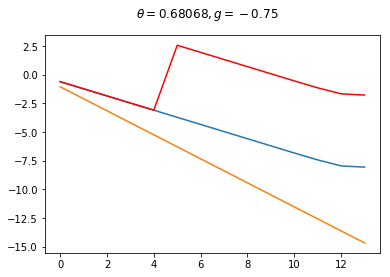

In [79]:
sel = data[0][15,13]
r = np.arange(1, 15)
y=np.array([Correlator(sigma, sigma**2, sel['GammaA'], sel['GammaB'], sel['LambdaA'], sel['LambdaB'], i, sel['chi']) for i in r])

angle=np.angle(y)
print(np.where(np.diff(angle)>0))
for i in np.where(np.diff(angle)>0)[0]:
    angle[i+1:]=angle[i+1:]-2*np.pi
plt.plot(r-1,angle)
plt.plot(np.angle(y), color='red')
plt.plot(r-1, -theta*r)
#plt.ylim(-np.pi, np.pi)
plt.suptitle(r'$\theta={}, g={}$'.format(sel['theta'], sel['g']))
plt.show()